In [45]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl

In [105]:
data = yf.download("ZEC-USD", start="2020-11-29", end="2022-11-29")

[*********************100%***********************]  1 of 1 completed


In [106]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-29,73.850639,75.587753,71.976891,74.582321,74.582321,475876224
2020-11-30,74.579430,78.958717,74.189430,78.128433,78.128433,630309432
2020-12-01,78.143730,80.914337,73.088104,75.096687,75.096687,820865601
2020-12-02,75.107803,76.502220,74.315819,76.402908,76.402908,456377852
2020-12-03,76.405602,76.538994,74.853279,75.910248,75.910248,382148819


In [107]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-24,43.158691,43.666737,42.454903,43.666737,43.666737,48363609
2022-11-25,43.659031,43.686218,41.303391,41.435005,41.435005,44551934
2022-11-26,41.435589,42.447781,41.241692,41.367966,41.367966,49540642
2022-11-27,41.365181,42.172516,40.613480,40.676304,40.676304,29360889
2022-11-28,40.673454,40.922478,38.982533,39.537876,39.537876,35179066


array([<AxesSubplot:xlabel='Date'>], dtype=object)

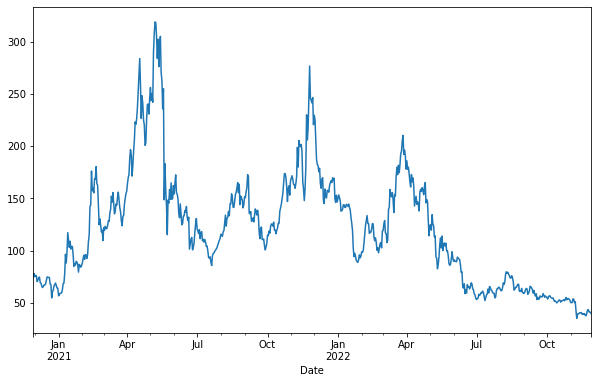

In [74]:
data.plot(figsize=(10, 6), subplots=True)

In [108]:
data.describe().round(2)

,Open,High,Low,Close,Adj Close,Volume
count,730.00,730.00,730.00,730.00,730.00,7.300000e+02
mean,120.59,126.26,114.39,120.47,120.47,4.076843e+08
std,54.94,58.93,50.94,54.86,54.86,4.516568e+08
min,35.22,38.70,34.16,35.22,35.22,2.691269e+07
25%,69.66,72.71,67.34,69.27,69.27,1.401329e+08
50%,117.60,121.96,112.44,117.51,117.51,2.741511e+08
75%,152.35,159.55,144.75,152.33,152.33,4.741565e+08
max,319.56,370.14,296.95,318.92,318.92,3.572146e+09


In [132]:
log_return = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

In [133]:
vol = np.sqrt(252) * log_return.std()
print('The annualised volatility is', round(vol*100,2), '%')


The annualised volatility is 103.88 %


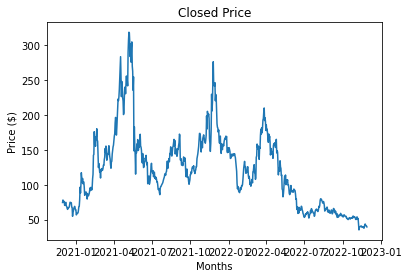

In [110]:
fig = mpl.figure()
mpl.plot(data['Close'])
mpl.xlabel('Months')
mpl.ylabel('Price ($)')
mpl.title('Closed Price');

# METHODOLOGIES

In [109]:
S = data['Adj Close'][-1]
print('The spot price is', round(S,2))

The spot price is 39.54


In [178]:
S0 = 39.54              # spot stock price
K = 40.00               # strike
T = 1.0                 # maturity 
r = 0.0368              # risk free rate 
sig = 1.0388            # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "put"          # payoff 

1. Binomial Model

In [179]:
dT = T / N                                    # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor 


In [180]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [181]:
S

array([[ 39.54      ,  72.02867311, 131.21218386, 239.02477237],
       [  0.        ,  21.70540609,  39.54      ,  72.02867311],
       [  0.        ,   0.        ,  11.91514045,  21.70540609],
       [  0.        ,   0.        ,   0.        ,   6.54079318]])

In [182]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.36409808046618647

In [183]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , 18.29459391],
       [ 0.        ,  0.        ,  0.        , 33.45920682]])

In [184]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[16.08147633,  7.21852316,  0.        ,  0.        ],
       [ 0.        , 21.46825863, 11.49173398,  0.        ],
       [ 0.        ,  0.        , 27.59719003, 18.29459391],
       [ 0.        ,  0.        ,  0.        , 33.45920682]])

In [185]:
print('European ' + payoff, str( V[0,0].round(2)))

European put 16.08


2. Monte Carlo Simulation

In [186]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [277]:
T = 1
r = 0.0368
sigma = 1.0388
S0 = 39.54
K = 40.00


In [287]:
S = mcs_simulation_np(2000)



In [288]:
S = np.transpose(S)
S

array([[ 39.54      ,  38.75384343,  37.77256011, ..., 144.54065388,
        143.4387732 , 142.13268204],
       [ 39.54      ,  39.88615087,  38.858575  , ...,  29.41252594,
         30.22748086,  29.84070178],
       [ 39.54      ,  39.6801262 ,  39.40421775, ...,  33.28122954,
         34.00072898,  33.81184903],
       ...,
       [ 39.54      ,  39.23944709,  40.74006163, ...,  14.21290148,
         13.82829946,  13.77682981],
       [ 39.54      ,  40.23885216,  39.7876712 , ...,  10.26026787,
          9.96360471,  10.16712267],
       [ 39.54      ,  39.33539719,  40.7793244 , ...,  19.27251663,
         19.38467365,  19.1736646 ]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

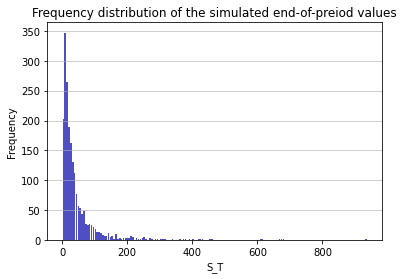

In [289]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [290]:
p = np.mean(np.maximum(K - S[:,-1],0))
print('European put', str(p))


European put 15.726859474014004


In [192]:
import scipy.stats as si

# GREEKS

In [221]:
from mpl_toolkits.mplot3d import Axes3D

In [222]:
def euro_option_bsm(S, K, T, r, q, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #q: continuous dividend yield
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value


In [223]:
euro_option_bsm(39.54, 40.00, 1, 0.0368, 0, 1.0388, 'put')

14.994543712650684

In [291]:
S = np.linspace(20,40,60)
Put = np.zeros((len(S),1))
for i in range(len(S)):
        Put [i] = euro_option_bsm(S[i], 39.54, 1, 0.0368, 0, 1.0388, 'put')

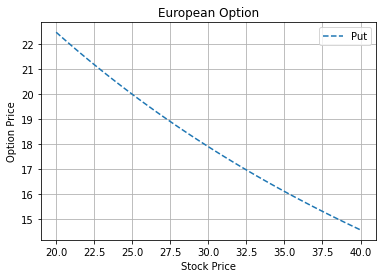

In [292]:
fig = plt.figure()
plt.plot(S, Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Option')
plt.legend(['Put'])

1. Delta

In [293]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [294]:
delta(39.54, 40, 1, 0.0368, 0, 1.0388, 'put')

-0.2933271055022363

In [295]:
S = np.linspace(20, 40, 60)
T = np.linspace(0.7, 1.4, 25)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 40, T[i], 0.0368, 0, 1.0388, 'put')

C:\Users\Queendarmie\AppData\Local\Temp\ipykernel_14200\3857024986.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


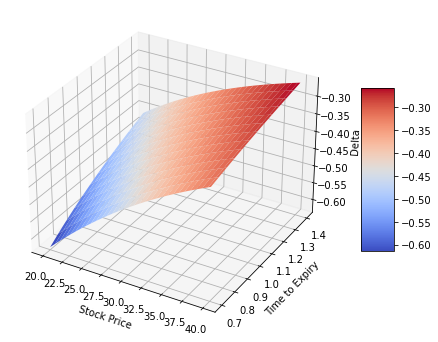

In [296]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

2. Gamma

In [297]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma


In [298]:
gamma(39.54, 40, 1, 0.0368, 0, 1.0388, 'put')

0.008378239777791995

In [299]:
S = np.linspace(20, 40, 60)
T = np.linspace(0.7, 1.4, 25)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], 40, T[i], 0.0368, 0, 1.0388, 'put')

C:\Users\Queendarmie\AppData\Local\Temp\ipykernel_14200\207610560.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


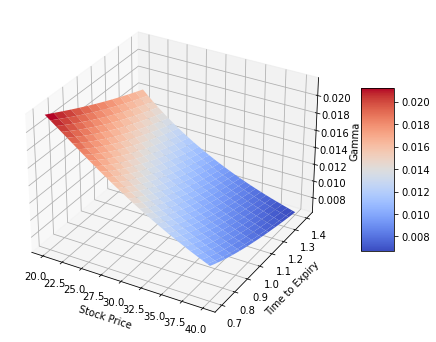

In [300]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);


3. Speed

In [301]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [302]:
speed(39.54, 40, 1, 0.0368, 0, 1.0388, 'put')

-0.0003227939561240622

In [303]:
S = np.linspace(20, 40, 60)
T = np.linspace(0.7, 1.4, 25)
Speed = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Speed[i,j] = speed(S[j], 40, T[i], 0.0368, 0, 1.0388, 'put')

C:\Users\Queendarmie\AppData\Local\Temp\ipykernel_14200\3257301218.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


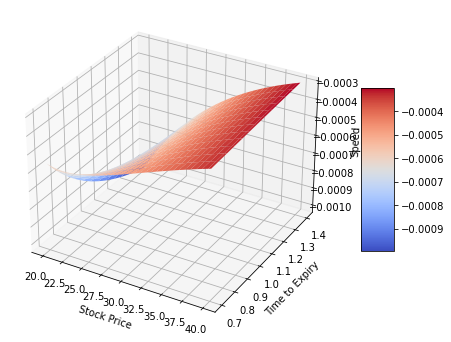

In [304]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Speed, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);


4. Theta

In [305]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) + q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) - r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [306]:
theta(39.54, 40, 1, 0.0368, 0, 1.0388, 'put')

6.08879409318313

In [307]:
S = np.linspace(20, 40, 60)
T = np.linspace(0.7, 1.4, 25)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], 40, T[i], 0.0368, 0, 1.0388, 'put')

C:\Users\Queendarmie\AppData\Local\Temp\ipykernel_14200\383283098.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


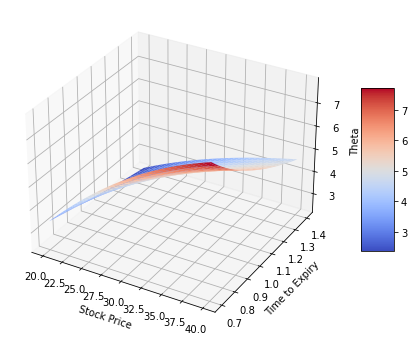

In [308]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

5. Rho

In [310]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [311]:
rho(39.54, 40, 1, 0.0368, 0, 1.0388, 'put')

-26.592697464209106

In [312]:
S = np.linspace(20, 40, 60)
T = np.linspace(0.7, 1.4, 25)
Rho = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Rho[i,j] = rho(S[j], 40, T[i], 0.0368, 0, 1.0388, 'put')


C:\Users\Queendarmie\AppData\Local\Temp\ipykernel_14200\2235945349.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


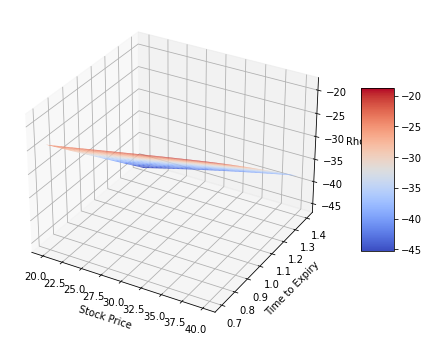

In [313]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Rho, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);

6. Vega

In [314]:
def vega(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [315]:
vega(39.54, 40, 1, 0.0368, 0, 1.0388, 'put')

13.606864381721266

In [316]:
S = np.linspace(20, 40, 60)
T = np.linspace(0.7, 1.4, 25)
Vega = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Vega[i,j] = vega(S[j], 40, T[i], 0.0368, 0, 1.0388, 'put')

C:\Users\Queendarmie\AppData\Local\Temp\ipykernel_14200\2704010610.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


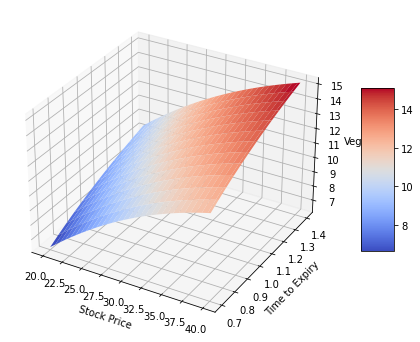

In [317]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Vega, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);
